In [438]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

# Homework 4

In [439]:
path = './dataset/bank+marketing/bank-full.csv'
df = pd.read_csv(path, delimiter=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [440]:
features = [
    'age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 
    'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y'
]
df = df[features]
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [441]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   balance    45211 non-null  int64 
 5   housing    45211 non-null  object
 6   contact    45211 non-null  object
 7   day        45211 non-null  int64 
 8   month      45211 non-null  object
 9   duration   45211 non-null  int64 
 10  campaign   45211 non-null  int64 
 11  pdays      45211 non-null  int64 
 12  previous   45211 non-null  int64 
 13  poutcome   45211 non-null  object
 14  y          45211 non-null  object
dtypes: int64(7), object(8)
memory usage: 5.2+ MB


In [442]:
# preprocess data
categorical_cols = list(df.dtypes[df.dtypes == 'object'].index)
 
for c in categorical_cols:
    df[c] = df[c].str.lower().str.replace(' ', '_')

# target encoding
df.y = (df.y == 'yes').astype(int)

# data spliting
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
 
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
 
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

len(df_train), len(df_val), len(df_test)

(27126, 9042, 9043)

## Q1: Highest feature AUC

In [443]:
# obtaining the auc score
numericals = list(df_train.dtypes[df_train.dtypes != 'object'].index)

auc_scores = {key: roc_auc_score(y_train, df_train[f'{key}']) for key in numericals}
auc_scores

{'age': np.float64(0.48781428247265596),
 'balance': np.float64(0.5888313805382317),
 'day': np.float64(0.474042117616092),
 'duration': np.float64(0.8147002759670778),
 'campaign': np.float64(0.42854569843178414),
 'pdays': np.float64(0.5901276247352144),
 'previous': np.float64(0.5985653242764153)}

In [444]:
# invert any variable with auc < 0.5
for key, val in auc_scores.items():
    if val < 0.5:
        auc_scores[key] = roc_auc_score(y_train, -df_train[key])

auc_scores

{'age': np.float64(0.512185717527344),
 'balance': np.float64(0.5888313805382317),
 'day': np.float64(0.525957882383908),
 'duration': np.float64(0.8147002759670778),
 'campaign': np.float64(0.5714543015682159),
 'pdays': np.float64(0.5901276247352144),
 'previous': np.float64(0.5985653242764153)}

In [445]:
# get key that has highest auc value
max(auc_scores, key=auc_scores.get)

'duration'

## Q2: Validation AUC

In [446]:
# one-hot encoding
dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

# model training
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [447]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

In [448]:
auc_score = roc_auc_score(y_val, y_pred)
np.round(auc_score, 2)

np.float64(0.9)

## Q3: Precision and recall

In [449]:
def pr_dataframe(y_val, y_pred):
    thresholds = np.arange(0.0, 1.01, 0.01)
    scores = []
    for t in thresholds:
        p = precision_score(y_val, y_pred >= t)
        r = recall_score(y_val, y_pred >= t)
        scores.append((t, p, r))

    cols = ['threshold', 'precision', 'recall']
    df_scores = pd.DataFrame(scores, columns=cols)

    return df_scores

result = pr_dataframe(y_val, y_pred)
result.head(10)

/home/microgix/virenv/course/202409282143_datatalks_ml/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,threshold,precision,recall
0,0.00,0.121433,1.000000
1,0.01,0.135095,0.996357
2,0.02,0.158820,0.995446
3,0.03,0.186385,0.989982
4,0.04,0.219392,0.972678
5,0.05,0.254122,0.954463
6,0.06,0.289034,0.928962
7,0.07,0.316949,0.904372
8,0.08,0.342524,0.882514
9,0.09,0.366563,0.860656


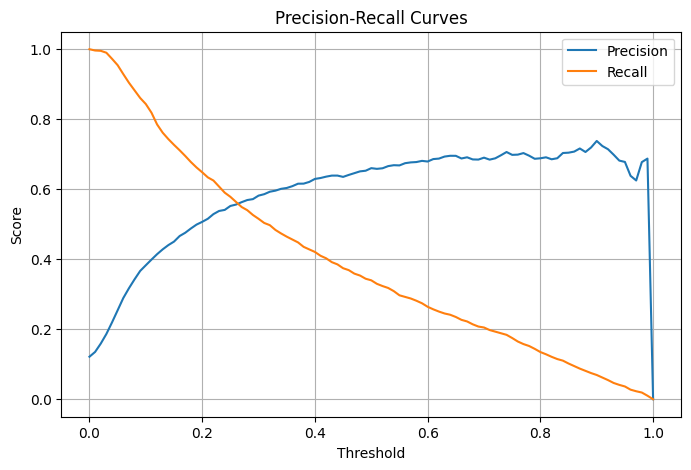

In [450]:
plt.figure(figsize=(8, 5))
plt.plot(result.threshold, result.precision, label='Precision')
plt.plot(result.threshold, result.recall, label='Recall')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)
plt.show()

## Q4: F1 score

In [451]:
def f1_score(row):
    p_score = row.precision
    r_score = row.recall
    if p_score + r_score == 0:
        return 0
    return 2*p_score*r_score/(p_score + r_score)

result['f1'] = result.apply(f1_score, axis=1)
result.loc[result.f1.idxmax()]

threshold    0.220000
precision    0.528913
recall       0.624772
f1           0.572860
Name: 22, dtype: float64

## Q5: STD for 5-fold CV

In [452]:
def encode(df_train, df_val):
    dv = DictVectorizer(sparse=False)
    
    train_dict = df_train.to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    val_dict = df_val.to_dict(orient='records')
    X_val = dv.transform(val_dict)

    return X_train, X_val
    
def train(X_train, y_train, C=1.0):
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return model

def predict(model, X_val):
    return model.predict_proba(X_val)[:, 1]

In [456]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
meter = tqdm(kfold.split(df_full_train))

scores = []
for train_idx, val_idx in meter:
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    df_train = df_train.drop('y', axis=1)
    df_val = df_val.drop('y', axis=1)

    X_train, X_val = encode(df_train, df_val)
    model = train(X_train, y_train)
    y_pred = predict(model, X_val)
 
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

np.std(scores)

0it [00:00, ?it/s]

np.float64(0.005652844370349586)

## Q6: Hyperparameter Tuning

In [458]:
for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        df_train = df_train.drop('y', axis=1)
        df_val = df_val.drop('y', axis=1)

        X_train, X_val = encode(df_train, df_val)
        model = train(X_train, y_train, C)
        y_pred = predict(model, X_val)
 
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.701 +- 0.009
C=0.001 0.861 +- 0.007
C=1 0.906 +- 0.006
